In [ ]:
import os
os.environ["keras_backend"] = "tensorflow"

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Input
from keras.layers import Conv1D
from keras.models import Sequential
import itertools
import matplotlib.pyplot as plt
import scipy
from scipy import signal
%matplotlib inline



C:\local\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load test data

In [2]:
data=np.load('overnight_all_compressed.npz')
eval_data = data['arr_2']

Load train data from zip file and merge all files in to single array

In [3]:
#x = np.load('overnight_all_compressed_new.npz')
#print(x)
#x_t=[]
final_array=np.array([])

a = data['arr_0']
b = data['arr_1']

print(a.shape)
print(b.shape)


final_array=np.vstack([a,b])

print(final_array.shape)

'''for i in x:
    
    print(x[i].shape)
    temp=x[i]
    final_array = np.hstack()
    final_array = np.concatenate((final_array,temp),axis=0)'''
    #np.concatenate(p,x[i])
    #p =np.concatenate((p,temp),axis=0)
    #np.append(x[i])
    
#data=['seconds','mic (trachea)','abdominal movement (stretch sensor)','thorax movement (stretch sensor)']
#x = pd.DataFrame(x['arr_0'], columns = data)
#x = pd.DataFrame(x['arr_1'], columns = data)

#merged = list(itertools.chain.from_iterable(x_t))


(11044514, 4)
(4769867, 4)
(15814381, 4)


'for i in x:\n    \n    print(x[i].shape)\n    temp=x[i]\n    final_array = np.hstack()\n    final_array = np.concatenate((final_array,temp),axis=0)'

Divide data into X & Y sets for the train and validation data

In [4]:
X_train = final_array[:,1]
Y_train = final_array[:,2]

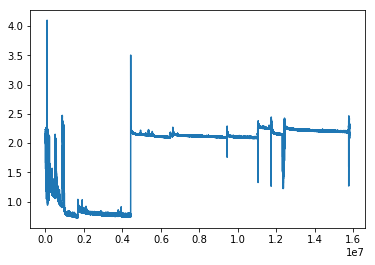

In [22]:
plt.plot(Y_train)

In [38]:
print(5//2)

2


In [47]:
def median_filter(x, n):    
    # very slow implementation!
    output = np.zeros(len(x)-n)
    # slide the window
    for i in range(n//2, len(x)-n-n//2):
        ar[i+n//2,4] = np.median(x[i:i+n])
        
    return ar

In [48]:
print(final_array.shape[0])
n = np.zeros([final_array.shape[0],1])
print(n.shape)
ar=np.hstack([final_array,n])
print(ar.shape)
print(ar[:,4])
print(np.diff(ar[:,2],axis=0))
ar[:,4]=np.gradient(ar[:,2],axis=0)


15814381
(15814381, 1)


MemoryError: 

-1.028251
530.2489850999991


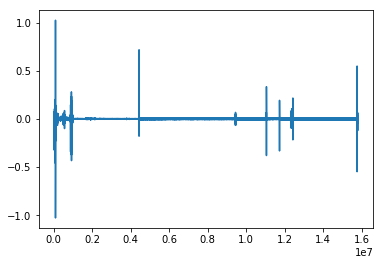

In [44]:
plt.plot(ar[:,4])
print(np.min(ar[:,4]))
import timeit
start=timeit.default_timer()
v=median_filter(ar,11)
stop=timeit.default_timer()
print(stop-start)

(15814381, 5)


MemoryError: 

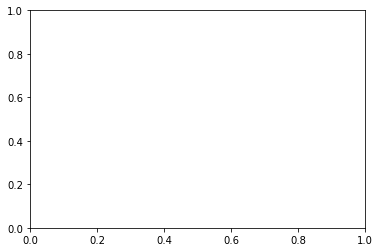

In [49]:
#np.append([v,[0]])
print(v.shape)
ar[:,4]=np.cumsum(ar[:,4])
#v=(np.cumsum(v))
#ar[:,4]=v
plt.plot(v[:,4])

In [20]:
h = np.zeros([ar.shape[0],1])
print(h.shape)
arr=np.hstack([ar,h])
print(arr.shape)
print(arr[:,5])
print(np.cumsum(arr[:,4],axis=0))
arr[:,5]=np.cumsum(ar[:,4],axis=0)


(15814381, 1)
(15814381, 6)
[0. 0. 0. ... 0. 0. 0.]
[2.00100e-03 2.00100e-03 5.00000e-07 ... 9.10225e-02 9.20230e-02
 9.40240e-02]


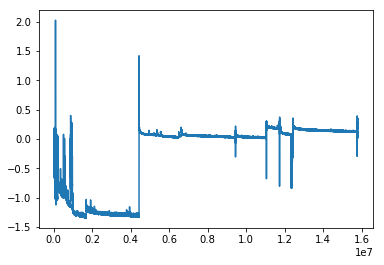

In [21]:
plt.plot(arr[:,5])

In [ ]:
# note: try differencing, median filtering and cumsum to remove offset spikes

#z = median_filter(Y_train,5)

# m= np.diff(Y_train,axis=0)

import timeit
start=timeit.default_timer()
z=scipy.signal.medfilt(final_array,101)
stop=timeit.default_timer()
print(stop-start)



plt.plot(Y_train)
#plt.show()

In [ ]:
plt.plot(z,label='diff')

Divide X & Y sets for the test data

In [ ]:
time=eval_data[:100000,0]
x_pred=eval_data[:100000,5].reshape(100000,1,1)
y_true=eval_data[:100000,2]

model 1 with 1D Convolution layers and final dense/FC layer with filter of size 1,1,1

In [ ]:
def Conv_test():
    model = Sequential()
    model.add(Convolution1D(32,1,border_mode='same',activation='relu'))
    model.add(Convolution1D(16,1,border_mode='same',activation='relu'))
    model.add(Convolution1D(2,1,border_mode='same',activation='relu'))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

model 2 with 1D Convolution layers and final dense/FC layer with filter of size 3, 1, 1

In [ ]:
def Conv1D_test():
    model = Sequential()    
    model.add(Conv1D(64,3,padding='same',activation='relu', input_shape=(1000,1)))
    model.add(Conv1D(16,1,padding='same',activation='relu'))
    model.add(Conv1D(2,1,padding='same',activation='relu'))
    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

Split train data into train and validation using scikit method

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_train,Y_train, test_size=0.33)

manually splitting train data  into train (70%) and validation (30% )

In [ ]:
l= len(X_train)
Xtrain = X_train[:round(l*0.7)]
Xtest = X_train[round(l*0.7)+1:]
ytrain = Y_train[:round(l*0.7)]
ytest = Y_train[round(l*0.7)+1:]

In [ ]:
window_size = 1000
leftover = len(Xtrain)%window_size

X_reshaped_train=(Xtrain[:-leftover]).reshape(-1,window_size,1)
print(X_reshaped_train.shape)

y_reshaped_train=(ytrain[:-leftover]).reshape(-1,window_size,1)

leftover_test = len(Xtest)%window_size

X_reshaped_test=(Xtest[:-leftover_test]).reshape(-1,window_size,1)
y_reshaped_test=(ytest[:-leftover_test]).reshape(-1,window_size,1)



In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


# Xtrain=(Xtrain).reshape(len(Xtrain),1,1)

# ytrain=ytrain.reshape(len(ytrain),1,1)

# Xtest=Xtest.reshape(len(Xtest),1,1)

# ytest=ytest.reshape(len(ytest),1,1)

validationData=(Xtest,ytest)
'''
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)'''
print(Xtrain.shape)

model=Conv1D_test()
history = model.fit(X_reshaped_train,y_reshaped_train,
                    validation_data=(X_reshaped_test, y_reshaped_test),
                    epochs=10,batch_size=50,
                    callbacks=[early_stopping])

In [ ]:
print(history.history.keys())
#y_pred=model.predict(x_pred)
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:


y_pred=model.predict(x_pred)
print(y_pred.shape)
y_pred= y_pred.reshape(100000,1)
fig = plt.figure(figsize=(20,10))
#for ix,items in zip([1,2],x):
ax = fig.add_subplot(2,1,1)
ax.set_title('Time vs Patient Data')
ax.set_xlabel('Time(in sec)')
ax.set_ylabel('Patient Data')
ax.plot(time,y_pred,label='abdominal movement (stretch sensor)_pred')
ax.plot(time,y_true,label='abdominal movement (stretch sensor)_true')



ax.legend()


In [ ]:
from sklearn.model_selection import TimeSeriesSplit


tscv = TimeSeriesSplit(n_splits=1)

for train, test in tscv.split(final_array):
    print(len(train))
    print(len(test))
    X_train=(final_array[train][:,1]).reshape(1,len(train),1)
    #X_train=X_train.reshape(1,len(train),1)
    Y_train=final_array[train][:,2].reshape(1,len(train),1)
    #Y_train.reshape(1,len(train),1)
    X_test=final_array[test][:,1].reshape(1,len(test),1)
    #X_test.reshape(1,len(test),1)
    Y_test=final_array[test][:,2].reshape(1,len(test),1)
    #Y_test.reshape(1,len(test),1)
    validationData=(X_test,Y_test)
    
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)
    print(Y_test.shape)
    model=Conv_test()
    history = model.fit(X_train,Y_train,epochs=50,batch_size=10, verbose=2)
    print(history.history.keys())
    #y_pred=model.predict(x_pred)
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
model = Sequential()

#model.add(Embedding(max_features, 128))

model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='relu'))



# try using different optimizers and different optimizer configs

model.compile(loss='mean_squared_error',

              optimizer='adam',

              metrics=['accuracy'])



print('Train...')

model.fit(x_train, y_train,

          batch_size=batch_size,

          epochs=15,

          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test,

                            batch_size=batch_size)